INFO: Query finished. [astroquery.utils.tap.core]


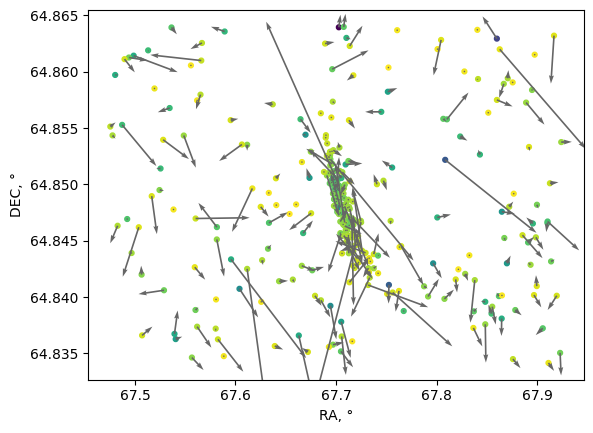

In [22]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
#def correct_pm(x):
#    if x=="--":
#        return 0
        
coord = SkyCoord("04:30:47.99", "+64:50:56.5", unit=(u.hourangle, u.deg), frame='icrs')
width = u.Quantity(0.03, u.hourangle)
height = u.Quantity(0.03, u.deg)
Gaia.ROW_LIMIT = -1
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#r.pprint(max_lines=12, max_width=1000)
plt.scatter(r["ra"], r["dec"], 
            c=r["phot_g_mean_mag"], s=12)

#r['pmdec'] = r['pmdec'].apply(correct_pm)
plt.quiver(r["ra"].filled(0), r["dec"].filled(0), r["pmra"].filled(0), r["pmdec"].filled(0), color='0.4')
plt.xlabel("RA, °")
plt.ylabel("DEC, °")
plt.show()

INFO: Query finished. [astroquery.utils.tap.core]
         dist              solution_id             DESIGNATION             source_id      random_index ref_epoch         ra              ra_error              dec             dec_error             parallax         parallax_error   parallax_over_error         pmra             pmra_error             pmdec             pmdec_error      ra_dec_corr  ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr ...         l                  b               ecl_lon           ecl_lat       priam_flags  teff_val teff_percentile_lower teff_percentile_upper a_g_val a_g_percentile_lower a_g_percentile_upper e_bp_min_rp_val e_bp_min_rp_percentile_lower e_bp_min_rp_percentile_upper flame_flags radius_val radius_percentile_lower radius_percentile_upper  lum_val  lum_percentile_lower lum_percentile_upper                                                                     datalink_url                                        

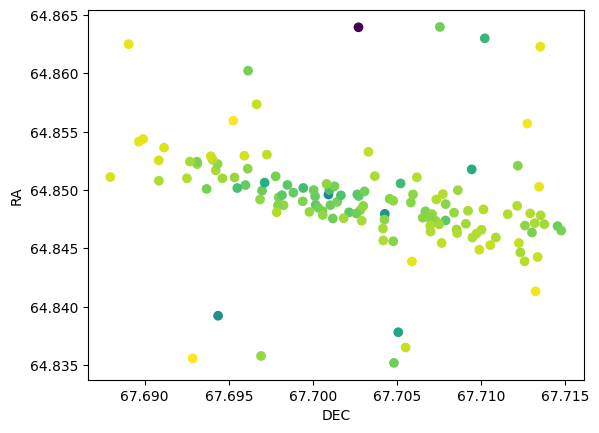